In [5]:
import os
print(os.getcwd())


C:\Users\harsh\Desktop\GitHub Repos\RecSys


## Loading the reviews file

In [10]:
import pandas as pd
import numpy as np # We'll use this for a specific type

# --- 1. Load the REVIEWS (the .csv.gz file) ---
print("Loading reviews (Electronics.csv.gz)...")

reviews_df = pd.read_csv(
    'data/Electronics.csv.gz', 
    compression='gzip',
    header=None,
    skiprows=1,
    names=['reviewerID', 'asin', 'overall', 'unixReviewTime'],
    
    # --- THIS IS THE FIX ---
    # We explicitly tell pandas what data type each column is.
    dtype={
        'reviewerID': 'str', 
        'asin': 'str', 
        'overall': 'float32',  # Use float32 to save memory (vs float64)
        'unixReviewTime': 'int64'
    }
)

print("Reviews loaded!")
print(reviews_df.info()) # .info() is great to check if dtypes are correct
print(reviews_df.head())

Loading reviews (Electronics.csv.gz)...
Reviews loaded!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15473536 entries, 0 to 15473535
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewerID      object 
 1   asin            object 
 2   overall         float32
 3   unixReviewTime  int64  
dtypes: float32(1), int64(1), object(2)
memory usage: 413.2+ MB
None
                     reviewerID        asin  overall  unixReviewTime
0  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B0047T79VS      3.0   1344406083000
1  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B01HHURN3W      3.0   1408995743000
2  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B00L0YLRUW      1.0   1439226089000
3  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B017T99JPG      5.0   1456772365000
4  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B01LW71IBJ      5.0   1456772571000


## 1. Find Key Entities (Users and Items)

In [11]:
# Get the number of unique users, items, and total reviews
num_users = reviews_df['reviewerID'].nunique()
num_items = reviews_df['asin'].nunique()
num_reviews = len(reviews_df)

print(f"Total Reviews: {num_reviews}")
print(f"Unique Users:  {num_users}")
print(f"Unique Items:  {num_items}")

Total Reviews: 15473536
Unique Users:  1641026
Unique Items:  368228


## 2. Calculate Sparsity

High percentage: It means the average user has only interacted with a tiny fraction of all available items.

In [12]:
# Calculate sparsity
sparsity = 1.0 - (num_reviews / (num_users * num_items))

print(f"Sparsity: {sparsity * 100:.4f}%")

Sparsity: 99.9974%


## 3. Plot the Ratings Distribution

This plot will almost certainly be "J-shaped," with a massive number of 5-star reviews. This is important for when we decide what a "positive" interaction is (e.g., 4.0 and 5.0 stars).


Plotting ratings distribution...


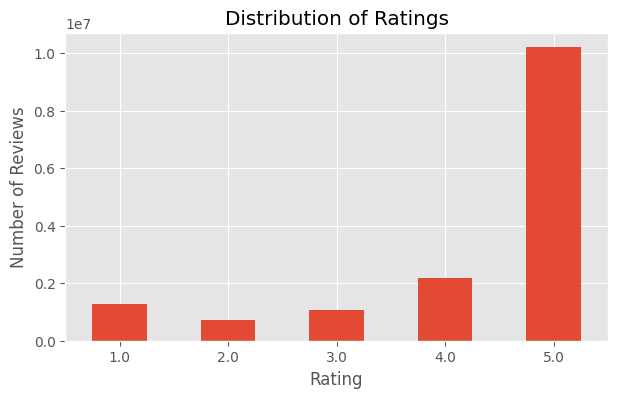

In [13]:
import matplotlib.pyplot as plt

print("\nPlotting ratings distribution...")

# Set a nice style for the plot
plt.style.use('ggplot')

reviews_df['overall'].value_counts().sort_index().plot(
    kind='bar',
    title='Distribution of Ratings',
    xlabel='Rating',
    ylabel='Number of Reviews',
    figsize=(7, 4)
)
plt.xticks(rotation=0) # Keep x-axis labels horizontal
plt.show()

What Our EDA Results Mean
* Counts (1.64M Users, 368.2K Items): This is excellent. The numbers align perfectly with the "5-core" dataset page. It's a large, meaningful dataset that's still manageable for a college project.

* Sparsity (99.9974%): This is the single most important number you've calculated. It's the central challenge of our project. It means that out of all possible user-item pairs, we only have data for 0.0026% of them.

This is why simple approaches fail. We can't just "look up" what a user thinks of an item, because they haven't rated 99.9974% of them.
<br>
Our goal is to predict preferences within this massive-but-empty space. This is why we need advanced models like Matrix Factorization and the Two-Tower hybrid, which can generalize from the tiny bit of data we do have.

* Rating Distribution (The J-Shaped Plot): Your plot is the classic "J-shape" of e-commerce reviews. The vast majority of ratings are 5-star. This confirms our plan for Phase 2: we will define a "positive" interaction as any rating overall >= 4.0, which is the industry-standard approach for a ranking model.

.jsonl stands for JSON Lines.

This means each line in the file is its own, separate JSON object (like a dictionary).

Our parse function, which reads the file line by line (for l in g:) and loads each line as a JSON object (yield json.loads(l)), is specifically designed for the JSON Lines format.

In [ ]:
# waayyy toooo large taking more timmeee
# dont run until optimiseddddd

# --- 2. Load the METADATA (the .json.gz file) ---
# We STILL need this for our hybrid model
# This file needs the helper functions from before

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df_dict = {}
    for d in parse(path):
        df_dict[i] = d
        i += 1
    return pd.DataFrame.from_dict(df_dict, orient='index')

# --- 1. Load the METADATA (meta_Electronics.json.gz) ---
print("\nLoading metadata (meta_Electronics.json.gz)...")
try:
    meta_df = getDF('data/meta_Electronics.jsonl.gz')
    print("Metadata loaded!")
    print(meta_df.info())
    print(meta_df.head())
except FileNotFoundError:
    print("---")
    print("ERROR: meta_Electronics.json.gz not found.")
    print("Please go back to the main UCSD page and download meta_Electronics.json.gz")
    print("We need this for our hybrid model's content features!")


Loading metadata (meta_Electronics.json.gz)...


KeyboardInterrupt: 

In [ ]:
# dont run until optimiseddd

# --- 2. Merge Reviews and Metadata ---
# We will do an 'inner' merge on 'asin'. This keeps only the
# items that are present in BOTH DataFrames.

print("\nMerging reviews_df and meta_df...")
# We only select a few useful columns from meta_df to merge
# to keep our DataFrame small and efficient.
meta_df_small = meta_df[['asin', 'title', 'brand', 'category']]

# Merge!
merged_df = pd.merge(reviews_df, meta_df_small, on='asin', how='inner')

print("Merge complete!")
print(merged_df.info())
print(merged_df.head())